# Assignment — Node classification

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, mutual_info_score, accuracy_score
from sklearn.datasets import make_moons
from sklearn.neighbors import kneighbors_graph
import requests
from sklearn.cluster import k_means
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import balanced_accuracy_score, mean_squared_error, mutual_info_score

### Task 1. Assortativity analysis (0 points)

In [2]:
url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/569720_ego_pokec.gml'
open('569720_ego_pokec.gml', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/musae_facebook_ego_802.gml'
open('musae_facebook_ego_802.gml', 'wb').write(requests.get(url).content)

url = 'https://raw.githubusercontent.com/netspractice/network-science/main/datasets/polblogs.gml'
open('polblogs.gml', 'wb').write(requests.get(url).content);


If the structure of the network is known but the labels of the nodes are hidden, we would like to select a small subset of nodes such that, if we knew their labels, we could accurately predict the labels of all the other nodes. However, it makes sence if labels depend of network structure. A few next models work well upon the assumption of high assortativity mixing. Let us remind that assortative mixing is the tendency for nodes to be connected to other nodes that are like them in some way. Assortativity coefficient bounded by
$$-1 \leq r \leq 1$$
where $r \to -1$ means that nodes tend to connect to nodes of the another class, $r \to 1$ — to the same class. Therefore, randomly mixed networks show $r \to 0$ for binary and numeric features, and $r < 0$ for categorical features.

It is also useful to know stastical error of assortativity coefficient, that can be calculated by jackknife method
$$\sigma_{r}^{2}=\sum_{i=1}^{M}\left(r_{i}-r\right)^{2}$$
where $r_i$ is the value of $r$ for the network in which the $i$-th edge is removed.

First, let us check assortativity coefficient for some networks and try to understand which labels can be predicted via network structure.

Write a function `assortativity_coefficients` that takes a graph, an optional list of categorical (or binary) features, an optional list of numerical features. It returns two dictionaries where keys are features, values are:
* assortativity coefficients
* estimated standard deviation $\sigma$

_Use `nx.attribute_assortativity_coefficient` and `nx.numeric_assortativity_coefficient`._

In [3]:
def assortativity_coefficients(G, categorical=[], numerical=[]):
    assortativity = {}
    std = {}

    def calc_ac_std(G, feature, is_numerical=True):
        ac_func = nx.numeric_assortativity_coefficient if is_numerical else nx.attribute_assortativity_coefficient
        edges = set(list(G.edges))

        base_AC = ac_func(G, attribute=feature)

        std_ = np.sqrt(np.sum(
            [
            np.square(
                ac_func(G.edge_subgraph(edges - set([edge])), attribute=feature)\
                      - base_AC
                )\
                for edge in edges
            ]
            ))

        return std_

    for c_val in categorical:
        AC = nx.attribute_assortativity_coefficient(G, attribute=c_val)
        assortativity[c_val] = AC
        std[c_val] = calc_ac_std(G, c_val, False)

    for n_val in numerical:
        AC = nx.numeric_assortativity_coefficient(G, attribute=n_val)
        assortativity[n_val] = AC
        std[n_val] = calc_ac_std(G, n_val, True)

    return assortativity, std

Calculating standard deviation takes much time for large graphs. Here is a function that selects random connected subgraph to speed up the calculation in this assignment.

In [4]:
def random_subgraph(G, n_nodes):
    np.random.seed(0)
    nodes = set()
    current_node = np.random.choice(G.nodes)
    while len(nodes) < n_nodes:
        next_node = np.random.choice(list(G.neighbors(current_node)))
        nodes.add(next_node)
        current_node = next_node
    return G.subgraph(nodes).copy()

Here is a subgraph of Slovakian online social network [Pokec](http://snap.stanford.edu/data/soc-Pokec.html)

In [5]:
G = nx.read_gml('569720_ego_pokec.gml')
G = random_subgraph(G, 200)

coef, std = assortativity_coefficients(
    G, ['public', 'gender', 'region'], ['age', 'completion_percentage'])
assert len(coef) == 5
assert round(coef['gender'], 4) == 0.0453
assert round(std['gender'], 4) == 0.0467
assert std['region'] < std['gender']

In [6]:
pd.DataFrame({'assortativity': coef, 'std': std}).round(4)

,assortativity,std
public,-0.2818,0.0190
gender,0.0453,0.0467
region,0.2440,0.0226
age,0.3230,0.0578
completion_percentage,0.0735,0.0475


* `public` is 1 if a person publishes his list of friends, and 0 otherwise
* `gender` is 1 for male and 0 for female
* `region` is a region of residence
* `age` is integer age
* `completion_percentage` is a percentage of completion information about a person

Next, look at a network of [political blogosphere in the 2004 US Election](http://www-personal.umich.edu/~mejn/netdata/).

In [7]:
G = nx.Graph(nx.read_gml('polblogs.gml'))
G = random_subgraph(G, 100)
coef, std = assortativity_coefficients(G, ['value', 'source'])
pd.DataFrame({'assortativity': coef, 'std': std}).round(4)

,assortativity,std
value,0.7645,0.0311
source,-0.0168,0.0095


The attribute `value` is political leaning that is divided into liberal and conservative. Also there is a category `source` where this information taken from.

Next, look at subgraph of the [Facebook large page-page network](http://snap.stanford.edu/data/facebook-large-page-page-network.html) restricted to pages from 4 categories which are defined by Facebook. These categories are: politicians, governmental organizations, television shows and companies.

In [8]:
G = nx.read_gml('musae_facebook_ego_802.gml')
G = random_subgraph(G, 100)
coef, std = assortativity_coefficients(G, ['value'])
pd.DataFrame({'assortativity': coef, 'std': std}).round(4)

,assortativity,std
value,0.6907,0.0289


Note that domain knowledge can help to preprocess the graph to get a higher assortativity.

### Task 2. Relational neighbor classifier (0 points)

Now let us start again with the facebook dataset and try to predict a page category (0.78 assortativity coefficient): politicians, governmental organizations, television shows and companies.

In [9]:
G = nx.read_gml('musae_facebook_ego_802.gml')
G = nx.convert_node_labels_to_integers(G)
len(G)

3873

Relational neighbor classifier is a simple probabilistic model for transductive semi-supervised learning on graphs. In contrast to *inductive* learning, *transductive* learning allows to use "test" set in training. Therefore, it is convinient to call train set as labeled set and test set as unlabeled set. 
* $X_L$ — labeled nodes
* $X_U$ — unlabeled nodes
* $Y_L$ — known labels
* $Y_U$ — unknown labels (hidden from the model)

Prepare labeled and unlabeled nodes to classification. Let us randomly select 30% of nodes as labeled nodes.

In [10]:
np.random.seed(0)
x_labeled = np.random.choice(G, size=int(0.3 * len(G)), replace=False)
x_unlabeled = np.array(list(set(G.nodes).difference(x_labeled)))

_labels = np.array(list(nx.get_node_attributes(G, 'value').values()))

print(_labels[::300])

['politician' 'government' 'politician' 'politician' 'government'
 'company' 'government' 'company' 'government' 'politician' 'company'
 'politician' 'company']


Convert labels into integers for simplicity

In [11]:
unique = list(set(_labels))
labels = np.array([unique.index(l) for l in _labels])
y_labeled = labels[x_labeled]
y_unlabeled = labels[x_unlabeled]
print(labels[::300])

[2 0 2 2 0 1 0 1 0 2 1 2 1]


Let us denote $y_i$ as label of a node $i$. Relational Neighbor Classifier based on a simple iterative procedure

$$P(y_i = c|\mathcal N(i)) = \frac{1}{Z}\sum_{j \in \mathcal N(i)}A_{ij}P(y_j = c|\mathcal N(j))$$

where $Z$ is a normalizing constant, $\mathcal N(i)$ is neighbors of node $i$. Note that this approach based on an assumption of strong assortativity — nodes related to each other are similar and likely belong to the same class. The algorithm is:

1. Set an initial conditional distribution $P_0$. Labeled nodes have a probability one in truth class and zeros in others. Unlabeled nodes have an equal probability of each class.
2. Update $P$ only for unlabeled nodes by the equation above
3. Repeat 2 until converges: $\Vert P_{i+1} - P_i \Vert < \varepsilon$
4. Predictions are labels with maximal probability

There is a function `relational_neighbor` that predicts labels. Parameters are:
* `G`: graph
* `threshold`: convergence threshold
* `y_labeled`: np.array, labels for labeled nodes
* `x_labeled`: np.array, labeled nodes
* `x_unlabeled`: np.array, unlabeled nodes

The function returns a np.array with labels for unlabeled nodes and np.array of norms of a distributions difference in each step before convergence.

In [12]:
def relational_neighbor(G, threshold, y_labeled, x_labeled, x_unlabeled):
    cond = initial_conditional(G, y_labeled, x_labeled, x_unlabeled)
    A = nx.to_numpy_array(G)
    diffs = []
    diff = np.inf
    while diff > threshold:
        next_cond = update_conditional(A, cond, x_labeled, x_unlabeled)
        diff = np.linalg.norm(cond[x_unlabeled] - next_cond[x_unlabeled])
        diffs.append(diff)
        cond = next_cond
    return np.argmax(cond[x_unlabeled], axis=1), diffs

Write a function `initial_conditional` that returns np.array with initial conditional distribution where $i$-th row represents probability of belonging of node $i$ to each class. Parameters are the same.

In [13]:
def initial_conditional(G, y_labeled, x_labeled, x_unlabeled):
    N = x_labeled.shape[0] + x_unlabeled.shape[0]
    k = np.unique(y_labeled).shape[0]
    P_init = np.ones((N, k)) * (1 / k)
    P_labeled = pd.get_dummies(y_labeled).values
    P_init[x_labeled, :] = P_labeled

    return P_init 

In [14]:
cond = initial_conditional(
    G, y_labeled, x_labeled, x_unlabeled)
assert cond.shape == (3873, 4)
assert np.all(cond.sum(axis=1) == 1)
assert np.all(cond[x_unlabeled] == 0.25)
assert set(np.unique(cond[x_labeled])) == {0, 1}

Write a function `update_conditional` that updates and returns np.array with conditional distribution.

In [15]:
def update_conditional(A, cond, x_labeled, x_unlabeled):
    P_new = (A @ cond) / (A @ cond).sum(axis=1).reshape(-1, 1)
    cond_new = cond.copy()
    cond_new[x_unlabeled,:] = P_new[x_unlabeled,:]

    return cond_new

In [16]:
A = nx.to_numpy_array(G)
cond = update_conditional(
    A, cond, x_labeled, x_unlabeled)
assert cond.shape == (3873, 4)
assert np.all(cond.sum(axis=1).round(4) == 1)
assert set(np.unique(cond[x_labeled])) == {0, 1}

Check convergence of the algorithm.

In [17]:
y_pred, diffs = relational_neighbor(
    G, 0.001, y_labeled, x_labeled, x_unlabeled)
score = balanced_accuracy_score(y_unlabeled, y_pred)
assert len(diffs) < 40
assert score > 0.7

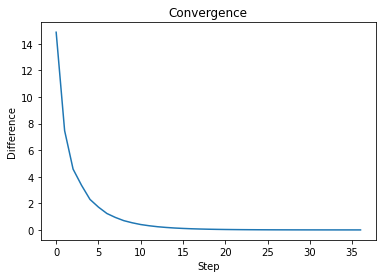

In [18]:
plt.plot(diffs)
plt.xlabel('Step')
plt.ylabel('Difference')
plt.title('Convergence')
plt.show()

In [19]:
print('Balanced accuracy:', round(score, 4))

Balanced accuracy: 0.7014


For comparison, a random guess is

In [20]:
score = balanced_accuracy_score(
    y_unlabeled,
    np.random.choice(range(4), size=len(x_unlabeled), replace=True)
)
print('Balanced accuracy:', round(score, 4))

Balanced accuracy: 0.2358


### Task 3. Label propagation classifier (3 points)

Consider the label propagation algorithm on an artificial dataset consisting of 3 sinusoids with noise.

In [21]:
N = 600
np.random.seed(0)
x_space = np.linspace(0, 3 * np.pi, int(N/3))
x1 = x_space + np.random.normal(0, 0.2, x_space.shape[0])
y1 = np.sin(x_space) + np.random.normal(0, 0.2, x_space.shape[0])
x2 = x_space + np.random.normal(0, 0.2, x_space.shape[0])
y2 = np.sin(x_space) + np.random.normal(0, 0.2, x_space.shape[0]) - 1.3
x3 = x_space + np.random.normal(0, 0.2, x_space.shape[0])
y3 = np.sin(x_space) + np.random.normal(0, 0.2, x_space.shape[0]) - 2.6

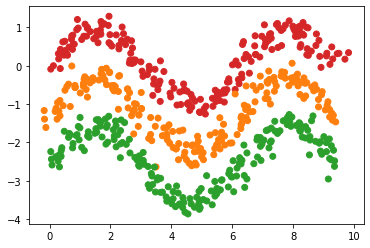

In [22]:
data_points = np.stack([np.concatenate([x1, x2, x3]), 
                        np.concatenate([y1, y2, y3])], axis=1)
plt.scatter(data_points[:, 0], data_points[:, 1], 
            c=np.repeat(['tab:red', 'tab:orange', 'tab:green'], 200));

Build a graph of k-neighbors of the data points.

In [23]:
A = kneighbors_graph(data_points, n_neighbors=8)
G = nx.Graph(A)
pos = {i:loc for i, loc in enumerate(data_points)}

Select 20 random labeled nodes. The goal is to predict an index of the sinusoid for other nodes.

In [24]:
np.random.seed(0)
x_labeled = np.random.choice(G, size=20, replace=False)
x_unlabeled = np.array(list(set(range(N)).difference(x_labeled)))

labels = np.array([0] * 200 + [1] * 200 + [2] * 200)
y_labeled = labels[x_labeled]
y_unlabeled = labels[x_unlabeled]

Draw the graph where train nodes are highlighted by colors with respect to a label.

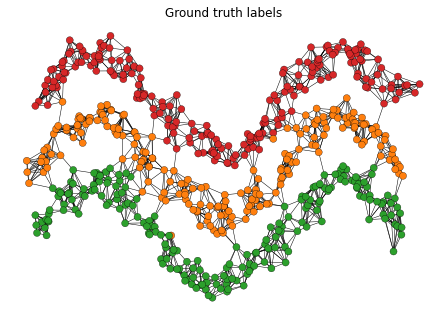

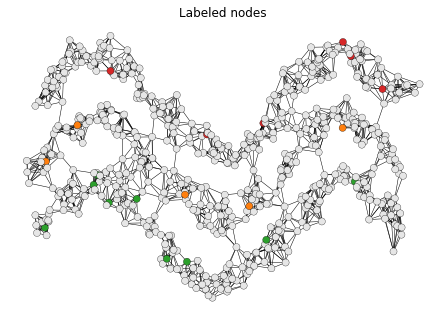

In [25]:
colors = np.array([plt.cm.tab10(3), plt.cm.tab10(1), plt.cm.tab10(2)])

node_color = colors[labels, :3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title('Ground truth labels')
plt.show()

node_color = np.ones((len(G), 3)) * 0.9
node_color[x_labeled] = colors[y_labeled, :3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title('Labeled nodes')
plt.show()

Label propagation method is also assume that closer data points tend to have similar class labels. Let us denote $Y$ as given label matrix, whose $i$-th row representing the label probability distribution of node $i$. Initialization of rows corresponding to unlabeled data points is not important, but let it be a uniform distribution. The algorithm is
1. Propagate $Y \leftarrow PY$ where $P$ is a transition matrix
2. Recover rows of $Y$ corresponding to labeled data points
3. Row-normalize $Y$ to maintain probability
4. Repeat 1-3 until $Y$ converges
5. Make a prediction as the most likely labels 

Here is a function `label_propagation` that returns predicted labels. Parameters are:
* `G`: graph
* `threshold`: convergence threshold
* `y_labeled`: np.array, labels for labeled nodes
* `x_labeled`: np.array, labeled nodes
* `x_unlabeled`: np.array, unlabeled nodes

The function returns a np.array with labels for unlabeled nodes and np.array of norms of a distributions difference in each step before convergence.

In [26]:
def label_propagation(G, threshold, y_labeled, x_labeled, x_unlabeled):
    y = initital_labels(G, y_labeled, x_labeled, x_unlabeled)
    P = transition_matrix(G)
    while True:
        next_y = update_labels(P, y, y_labeled, x_labeled, x_unlabeled)
        if np.linalg.norm(y - next_y) < threshold:
            break
        y = next_y
    y_pred = np.argmax(y, axis=1)[x_unlabeled]
    return y_pred

Write a function `initital_labels` that returns np.array with initial label matrix. Parameters are the same.

In [27]:
def initital_labels(G, y_labeled, x_labeled, x_unlabeled):
    N = x_labeled.shape[0] + x_unlabeled.shape[0]
    k = np.unique(y_labeled).shape[0]
    P_init = np.ones((N, k)) * (1 / k)
    P_labeled = pd.get_dummies(y_labeled).values
    P_init[x_labeled, :] = P_labeled

    return P_init 

In [28]:
y = initital_labels(G, y_labeled, x_labeled, x_unlabeled)
assert y.shape == (len(G), len(set(y_labeled)))
assert np.all(y.sum(axis=1) == 1)
assert y[x_labeled].max() == 1
assert y[x_labeled].min() == 0

Write a function `transition_matrix` that returns np.array with transition matrix.

In [29]:
def transition_matrix(G):
    def transition_from_adjacency(A):
        A = np.array(A)
        d = A.sum(axis=1).flatten()
        d[d==0] = 1
        D = np.diag(d)
        D1 = np.linalg.inv(D)
        
        return D1 @ A
    
    A = nx.to_numpy_array(G)
    P = transition_from_adjacency(A)

    return P

In [30]:
P = transition_matrix(G)
assert P.shape == (len(G), len(G))
assert np.all(P.sum(axis=1).round(4) == 1)

Write a function `update_labels` that returns np.array with updated label matrix.

In [31]:
def update_labels(P, y, y_labeled, x_labeled, x_unlabeled):
    Y_new = (P @ y) / (P @ y).sum(axis=1).reshape(-1, 1)
    Y_out = y.copy()
    Y_out[x_unlabeled,:] = Y_new[x_unlabeled,:]

    return Y_out

In [32]:
next_y = update_labels(P, y, y_labeled, x_labeled, x_unlabeled)
assert next_y.shape == (len(G), len(set(y_labeled)))
assert np.all(next_y.sum(axis=1).round(4) == 1)
assert next_y[x_labeled].max() == 1
assert next_y[x_labeled].min() == 0

y_pred = label_propagation(G, 0.001, y_labeled, x_labeled, x_unlabeled)
accuracy = accuracy_score(y_unlabeled, y_pred)
assert accuracy > 0.93

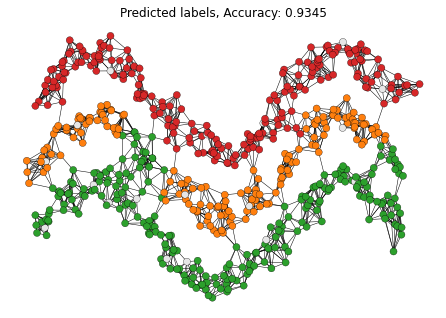

In [33]:
colors = np.array([plt.cm.tab10(3), plt.cm.tab10(1), plt.cm.tab10(2)])
node_color = np.ones((len(G), 3)) * 0.9
node_color[x_unlabeled] = colors[y_pred, :3]

nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title(f'Predicted labels, Accuracy: {accuracy:.4f}');

### Task 4. MultiRankWalk algorithm (3 points)

MultiRankWalk is a semi-supervised learning method that based on random graph walk. Its basic component is similar to personalized PageRank

$$r =\alpha P^T r + (1 - \alpha)v$$

where $v$ is a teleportation vector and $P$ is a transition matrix. In this method, labeled instances of each class is described by a vector $v$, where each non-zero element corresponds to a labeled node. For each class $c$, at every time step the process may follow a transition with probability $\alpha$ or it may decide to start the process again at an instance labeled $c$ with probability $1 − \alpha$. The process is repeated for every class and the class of an unlabeled instance is decided by which class $c$’s process visited the instance most often. Let us check the algorithm on the karate club graph.

In [34]:
G = nx.karate_club_graph()
x_labeled = np.array([32, 0, 1])
x_unlabeled = np.array(list(set(G.nodes).difference(x_labeled)))
labels = np.array([0 if G.nodes[n]['club'] == 'Mr. Hi' else 1 for n in G.nodes])
y_labeled = labels[x_labeled]
y_unlabeled = labels[x_unlabeled]

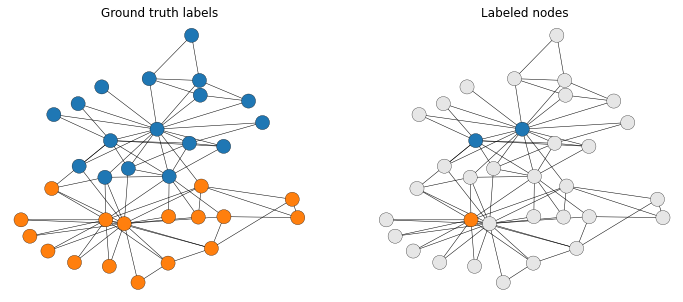

In [35]:
colors = np.array([plt.cm.tab10(0), plt.cm.tab10(1)])
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
node_color = colors[labels, :3]
nx.draw_kamada_kawai(G, node_size=200, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title('Ground truth labels')

plt.subplot(1, 2, 2)
node_color = np.ones((len(G), 3)) * 0.9
node_color[x_labeled] = colors[y_labeled, :3]
nx.draw_kamada_kawai(G, node_size=200, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title('Labeled nodes');

Here is a function `multirankwalk` that returns predicted labels. Parameters are:
* `G`: graph
* `y_labeled`: np.array, labels for labeled nodes
* `x_labeled`: np.array, labeled nodes
* `x_unlabeled`: np.array, unlabeled nodes

The function returns a np.array with labels for unlabeled nodes.

In [36]:
def multirankwalk(G, y_labeled, x_labeled, x_unlabeled, alpha):
    n_classes = len(set(y_labeled))
    y_pred = np.zeros((len(G), n_classes))
    for c in range(n_classes):
        y_pred[:, c] = personalized_pr(G, y_labeled, x_labeled, c, alpha)
    return y_pred.argmax(axis=1)[x_unlabeled]

Write a function `personalized_pr` that takes mentioned parameters, a class label `c` and transition probability `alpha` and returns np.array with personalized page rank values for all nodes. *Use `nx.pagerank`.*

In [37]:
def personalized_pr(G, y_labeled, x_labeled, c, alpha): 
    v_personalisation = {node_idx: int(y_labeled[i]==c) for i, node_idx in enumerate(x_labeled)}
    PR = nx.pagerank(G, alpha=alpha, personalization=v_personalisation)

    return np.array(list(PR.values()))

In [38]:
n_classes = len(set(y_labeled))
y_pred = np.zeros((len(G), n_classes))
y_pred_c = personalized_pr(G, y_labeled, x_labeled, c=0, alpha=0.8)
assert y_pred_c.shape == (34,)
assert np.all(y_pred_c.round(4)[:3] == [0.2115, 0.1682, 0.0592])
y_pred_c = personalized_pr(G, y_labeled, x_labeled, c=1, alpha=0.8)
assert np.all(y_pred_c.round(4)[:3] == [0.0354, 0.0241, 0.0472])
y_pred = multirankwalk(G, y_labeled, x_labeled, x_unlabeled, alpha=0.8)
accuracy = accuracy_score(y_unlabeled, y_pred)
assert accuracy > 0.96

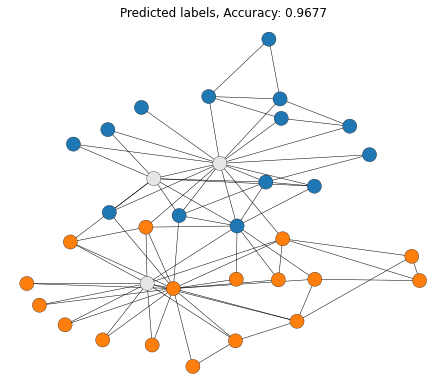

In [39]:
colors = np.array([plt.cm.tab10(0), plt.cm.tab10(1)])
node_color = np.ones((len(G), 3)) * 0.9
node_color[x_unlabeled] = colors[y_pred, :3]

plt.figure(figsize=(6, 5))
nx.draw_kamada_kawai(G, node_size=200, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title(f'Predicted labels, Accuracy: {accuracy:.4f}');

### Task 5. Ridge regression on graphs (4 points)

Consider node regression with Tikhonov ($L_2$, Ridge) regularization on an artificial dataset that was again converted into graph by k-neighbors.

In [40]:
N = 600
data_points, labels = make_moons(n_samples=N, noise=0.15, random_state=0)
A = kneighbors_graph(data_points, n_neighbors=5).toarray()
G = nx.Graph(A)
pos = {i:loc for i, loc in enumerate(data_points)}

np.random.seed(0)
x_labeled = np.random.choice(G, size=20, replace=False)
x_unlabeled = np.array(list(set(range(N)).difference(x_labeled)))
labels[labels == 0] = 10
labels[labels == 1] = 100
y_labeled = labels[x_labeled]
y_unlabeled = labels[x_unlabeled]

Here are labels of blue nodes equal to 10, reds equal to 100. Other labels are unknown.

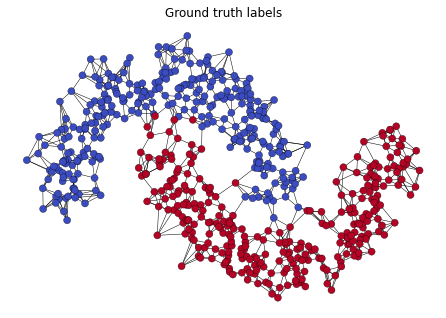

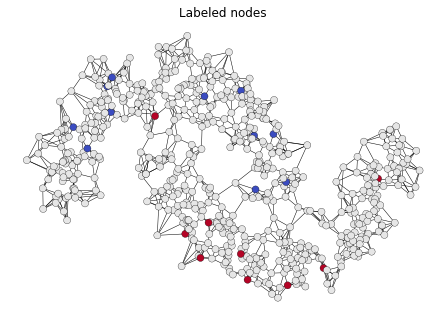

In [41]:
node_color = np.ones((len(G), 3)) * 0.9
node_color[labels == 10] = plt.cm.coolwarm(0)[:3]
node_color[labels == 100] = plt.cm.coolwarm(255)[:3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title('Ground truth labels')
plt.show()

node_color = np.ones((len(G), 3)) * 0.9
node_color[x_labeled[y_labeled == 10]] = plt.cm.coolwarm(0)[:3]
node_color[x_labeled[y_labeled == 100]] = plt.cm.coolwarm(255)[:3]
nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
        edgecolors='black', node_color=node_color)
plt.title('Labeled nodes')
plt.show()

Consider given node labels $\mathbf y$ and normalized labels

$$\tilde y_i = y_i - \frac{1}{k}\sum_{j=1}^k y_j$$ 

where $k$ is the number of known labels. Unknown labels are given as zeros. Let the function $\mathbf f$ be predicted labels of nodes. One way to think about such a function is that it does not make too many “jumps” under high assortativity assumption. We formalize that notion, by the smoothness penalty

$$\sum_{i \sim j} A_{i j}\left(f_{i}-f_{j}\right)^{2}=\mathbf{f}^{T} L \mathbf{f}$$

where $L$ is the Laplacian. That is, the objective is to minimize the MSE between known labels and function $\mathbf f$ plus the smoothness penalty $S = L^p$, where $p$ is an integer hyperparameter

$$\mathbf{\tilde f} = \text{argmin}_\mathbf{f}\left(\frac{1}{k}\sum_{i=1}^k(f_i - \tilde y_i)^2 + \gamma \mathbf{f}^T S \mathbf{f}\right)$$

The analytical solution is given as $\mathbf{\tilde f} = (k \gamma S + I)^{-1}\mathbf{\tilde y}$ where $I$ is a diagonal matrix with ones and zeros. $I_{ii} = 1$ if a label of $i$-th node is known.

_Remark: for the stability of the algorithm, we use $\tilde y_i$ instead of $y_i$._

Write a function `tikhonov_regularization` that takes coefficient of regularization, a power of Laplacian and returns predicted labels.

In [42]:
def tikhonov_regularization(G, gamma, y_labeled, x_labeled, x_unlabeled, p):
    A = nx.to_numpy_array(G)
    N = A.shape[0]

    d = A.sum(axis=1).flatten()
    d[d==0] = 1
    D = np.diag(d)

    L = D - A
    S = np.linalg.matrix_power(L, p)

    k = y_labeled.shape[0]

    I = np.zeros((N, ))
    I[x_labeled] = 1
    I = np.diag(I)

    y_tilde = np.zeros((N, )).reshape(-1, 1)
    y_norm_part = (1 / k) * np.sum(y_labeled)
    y_tilde[x_labeled,:] = y_labeled.reshape(-1, 1) - y_norm_part

    f = np.linalg.inv(k * gamma * S + I) @ y_tilde

    return (f[x_unlabeled, ] + y_norm_part).flatten()

In [43]:
y_pred = tikhonov_regularization(
    G, 0.001, y_labeled, x_labeled, x_unlabeled, p=1)
assert mean_squared_error(y_unlabeled, y_pred) < 282

y_pred = tikhonov_regularization(
    G, 0.001, y_labeled, x_labeled, x_unlabeled, p=2)
assert mean_squared_error(y_unlabeled, y_pred) < 325

Let us see how penalty and power of Laplacian affect to predicted labels.

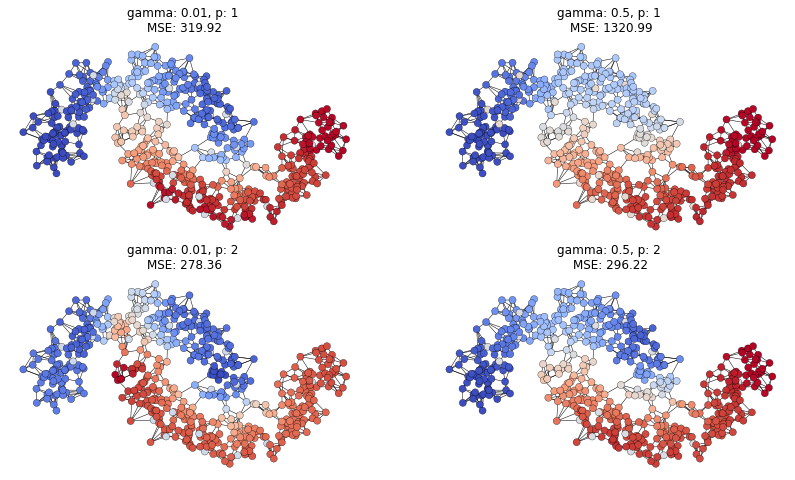

In [44]:
plt.figure(figsize=(14, 8))
for i, p in enumerate([1, 2]):
    for j, gamma in enumerate([0.01, 0.5]):
        y_pred = tikhonov_regularization(
            G, gamma, y_labeled, x_labeled, x_unlabeled, p=p)
        node_color = np.ones(len(G)) * y_labeled.mean()
        node_color[x_unlabeled] = y_pred
        mse = mean_squared_error(y_unlabeled, y_pred)
        plt.subplot(2, 2, (i + 1) * i + j + 1)
        nx.draw(G, pos, node_size=50, width=0.5, linewidths=0.3, 
                node_color=node_color, edgecolors='black', cmap=plt.cm.coolwarm)
        plt.title(f'gamma: {gamma}, p: {p} \nMSE: {mse:.2f}')

### Task 6. SVD node embedding (0 points)

Another way to classify nodes is to learn node embeddings and then use any supervised algorithm. One of the simplest way to obtain node embeddings is to apply SVD on adjacency matrix. The first step is to decompose the adjacency matrix $A$ into three matrices $U$
, $S$ and $V$ so that 

$$USV^T = A$$

Then we keep only $k$ first singular values, where $k$ is a number of dimensions of embedding. For example if $k=2$, then the 4x4 matrix $S$ is converted as follows

$$S = \begin{bmatrix}
\sigma_1 & 0 & 0 & 0 \\
0 & \sigma_2 & 0 & 0 \\
0 & 0 & \sigma_3 & 0 \\
0 & 0 & 0 & \sigma_4 \\
\end{bmatrix}
\Rightarrow
\begin{bmatrix}
\sigma_1 & 0 & 0 & 0 \\
0 & \sigma_2 & 0 & 0 \\
0 & 0 & 0 & 0 \\
0 & 0 & 0 & 0 \\
\end{bmatrix}$$

And then we compute embeddings as $E = US$ and use only non-zero columns. Let us consider SVD embedding on the Zachary's Karate Club graph.

Write a function `svd_adj` that takes a graph and returns 3 np.arrays with $U$, $S$, $V^T$ of an adjacency matrix. 

Hint: use `np.linalg.svd`

In [45]:
def svd_adj(G):
    A = nx.to_numpy_array(G)
    u, s, vt = np.linalg.svd(A)
    return u, np.diag(s), vt

In [46]:
G = nx.karate_club_graph()
A = nx.to_numpy_array(G)
u, s, vt = svd_adj(G)
A_ = u @ s @ vt
assert np.allclose(A, A_)

Write a function `svd_embedding` that takes np.arrays with $U$, $S$, a numer of dimensions $k$ and returns a np.array with node embeddings.

In [47]:
def svd_embedding(u, s, k):
    s_cut = s.copy()
    s_cut[k:, k:] = 0
    E = u @ s_cut
    E = E[:,:k]

    return E

In [48]:
attr = nx.get_node_attributes(G, 'club')
attr = ['tab:orange' if i == 'Mr. Hi' else 'tab:blue' for i in list(attr.values())]

G = nx.karate_club_graph()
u, s, vt = svd_adj(G)

emb = svd_embedding(u, s, 2)
assert emb.shape == (34, 2)

clf = LogisticRegression().fit(emb, attr)
assert 0.97 < clf.score(emb, attr) < 1

emb = svd_embedding(u, s, 8)
assert emb.shape == (34, 8)

clf = LogisticRegression().fit(emb, attr)
assert clf.score(emb, attr) == 1

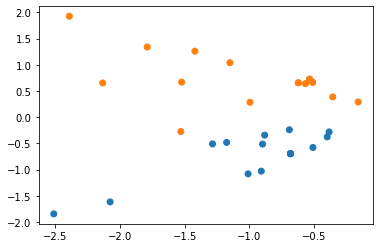

In [49]:
emb = svd_embedding(u, s, 2)
plt.scatter(emb[:, 0], emb[:, 1], c=attr)
plt.show()

As we see, SVD embeddings represent nodes in almost linearly seperable classes for the karate club graph.